## Passenger Satisfaction

In [1]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [1]:
#Running the necessary libraries from another notebook
%run Libraries.ipynb

C:\Users\Thosiba\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#Running useful pre-written functions from another notebook
%run Utility_tools.ipynb

In [3]:
raw = pd.read_csv('train.csv', index_col=[0])
df = deepcopy(raw) 

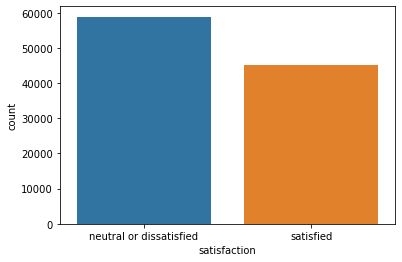

In [86]:
sns.countplot(df.satisfaction)
plt.show();

In [676]:
display(df[df.isna().any(axis=1)].shape[0], df.isna().sum()) 

310

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [4]:
df.rename(columns=lambda col: col.replace(' ', '_').replace('/', '_').lower(), inplace=True) 

In [5]:
reduce_memory_usage(df)

Memory usage before: 19.82 MB
Memory usage now : 3.77 MB
Memory usage decreased by 81.0%


In [6]:
df.loc[df.satisfaction=='satisfied'].shape[0]/df.shape[0]

0.43333269171542965

In [7]:
df.loc[~df['arrival_delay_in_minutes'].isna()].shape[0]/df.shape[0]

0.9970164767477672

In [8]:
df.drop('id', axis=1, inplace=True)

In [9]:
df.satisfaction = df.satisfaction.replace('satisfied', 1).replace('neutral or dissatisfied', 0).astype('int')

##### Fill in the missing

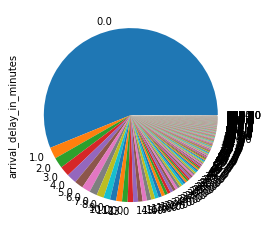

In [257]:
df['arrival_delay_in_minutes'].value_counts().plot(kind='pie')
plt.show(); 

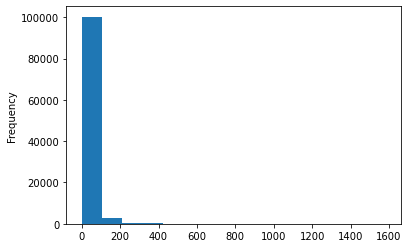

In [148]:
df['arrival_delay_in_minutes'].plot(kind='hist', bins=15)
plt.show();

In [10]:
df['arrival_delay_in_minutes'].fillna(value=0.0, inplace=True) 

In [11]:
duplicate_check_remove(df)

There are no duplicate rows in the dataset.


#### Let's determine which features to keep

In [12]:
df_cont = df.select_dtypes(include='number')
df_cat = df.select_dtypes(include='category')

In [13]:
#Some of our presumed continuous features are actually ordinal. We'll separate them.
for col in df_cont:
    print(f'''{col}: {df_cont.nunique()}''')

age: age                                    75
flight_distance                      3802
inflight_wifi_service                   6
departure_arrival_time_convenient       6
ease_of_online_booking                  6
gate_location                           6
food_and_drink                          6
online_boarding                         6
seat_comfort                            6
inflight_entertainment                  6
on-board_service                        6
leg_room_service                        6
baggage_handling                        5
checkin_service                         6
inflight_service                        6
cleanliness                             6
departure_delay_in_minutes            446
arrival_delay_in_minutes              455
satisfaction                            2
dtype: int64
flight_distance: age                                    75
flight_distance                      3802
inflight_wifi_service                   6
departure_arrival_time_convenient       6

on-board_service: age                                    75
flight_distance                      3802
inflight_wifi_service                   6
departure_arrival_time_convenient       6
ease_of_online_booking                  6
gate_location                           6
food_and_drink                          6
online_boarding                         6
seat_comfort                            6
inflight_entertainment                  6
on-board_service                        6
leg_room_service                        6
baggage_handling                        5
checkin_service                         6
inflight_service                        6
cleanliness                             6
departure_delay_in_minutes            446
arrival_delay_in_minutes              455
satisfaction                            2
dtype: int64
leg_room_service: age                                    75
flight_distance                      3802
inflight_wifi_service                   6
departure_arrival_time_conv

In [14]:
df_ord = df[[col for col in df_cont if df_cont[col].nunique()<10]]
df_cont = df[[col for col in df_cont.columns if col not in df_ord.columns[:-1]]]

In [15]:
#Comparing means
pd.pivot_table(data=df_cont, index='satisfaction', aggfunc=[np.mean ,np.median])  

mean                                                      \
                    age arrival_delay_in_minutes departure_delay_in_minutes   
satisfaction                                                                  
0             37.566688                17.078125                  16.503728   
1             41.750583                12.593750                  12.608084   

                             median                           \
             flight_distance    age arrival_delay_in_minutes   
satisfaction                                                   
0                 928.919971     36                      0.0   
1                1530.140255     43                      0.0   

                                                         
             departure_delay_in_minutes flight_distance  
satisfaction                                             
0                                     0             671  
1                                     0            1250

In [16]:
#Checking equal variances assumption. Mostly violated, so we continue with Welch T-test
pd.pivot_table(data=df_cont, index='satisfaction', aggfunc=np.var)

,age,arrival_delay_in_minutes,departure_delay_in_minutes,flight_distance
satisfaction,,,,
0,270.925845,1641.0,1615.387665,6.248149e+05
1,163.017569,1290.0,1251.928044,1.272670e+06


##### Independent sample T-test

In [17]:
for col in df_cont.columns:
    print(f'''P-value for {col}: {ttest(df_cont[df_cont['satisfaction']==0][col], 
          df_cont[df_cont['satisfaction']==1][col], correction='auto').T.iloc[3,:][0]} ''') 

P-value for age: 0.0 
P-value for flight_distance: 0.0 
P-value for departure_delay_in_minutes: 1.2767076513246778e-61 
P-value for arrival_delay_in_minutes: 1.0 
P-value for satisfaction: 0.0 


#### Based on the results above, I suspected that some continuous features don't have an influence on satisfaction. I fit the model with and without them and the performance results were the same. So, to reduce dimensionality, I discard those features.    

In [18]:
df_cont.drop(['departure_delay_in_minutes', 'arrival_delay_in_minutes'], axis=1, inplace=True)

#### Variance Threshold

In [19]:
from sklearn.feature_selection import VarianceThreshold
print(df_cont.shape)     
var_filter = VarianceThreshold(threshold = 0.0)  
train = var_filter.fit_transform(df_cont)
print(train.shape)  #All of them remained       

(103904, 3)
(103904, 3)


#### Coercing outliers

In [20]:
find_outliers_iqr(df_cont)

Number of outlier records in age column: 0
Number of outlier records in flight_distance column: 2291
Number of outlier records in satisfaction column: 0


In [21]:
def coerce_outliers(value):
    if value > upperlimit:
        value = upperlimit
    elif value < lowerlimit:
        value = lowerlimit
    return value

for feature in df_cont.columns:
    Q3 = df_cont[feature].quantile(q = 0.75)
    Q1 = df_cont[feature].quantile(q = 0.25)
    IQR = Q3 - Q1 
    outlier_range = IQR * 1.5
    upperlimit = Q3 + outlier_range
    lowerlimit = Q1 - outlier_range
    df_cont[feature] = df_cont[feature].apply(coerce_outliers)

##### Now, let's check which categorical features are a good predictor for satisfaction. We'll conduct Chi-Square test for this

In [22]:
#We've got very few categories, but should we use one-hot encoding we'll end up with 9 columns
for col in df_cat:
    print(f'''Number of unique values for {col}: {df_cat[col].nunique()}''') 

Number of unique values for gender: 2
Number of unique values for customer_type: 2
Number of unique values for type_of_travel: 2
Number of unique values for class: 3


In [23]:
expected, observed, stats = chi2_independence(data=df, x='gender', y='satisfaction')
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,15.444,1.0,0.0,0.012,0.976
1,cressie-read,0.667,15.444,1.0,0.0,0.012,0.976
2,log-likelihood,0.000,15.444,1.0,0.0,0.012,0.976
3,freeman-tukey,-0.500,15.444,1.0,0.0,0.012,0.976
4,mod-log-likelihood,-1.000,15.445,1.0,0.0,0.012,0.976
5,neyman,-2.000,15.445,1.0,0.0,0.012,0.976


In [24]:
expected, observed, stats = chi2_independence(data=df, x='customer_type', y='satisfaction')
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,3657.281,1.0,0.0,0.188,1.0
1,cressie-read,0.667,3712.795,1.0,0.0,0.189,1.0
2,log-likelihood,0.000,3862.001,1.0,0.0,0.193,1.0
3,freeman-tukey,-0.500,4012.079,1.0,0.0,0.197,1.0
4,mod-log-likelihood,-1.000,4200.572,1.0,0.0,0.201,1.0
5,neyman,-2.000,4720.406,1.0,0.0,0.213,1.0


In [25]:
expected, observed, stats = chi2_independence(data=df, x='type_of_travel', y='satisfaction')
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,20945.234,1.0,0.0,0.449,1.0
1,cressie-read,0.667,21556.577,1.0,0.0,0.455,1.0
2,log-likelihood,0.000,23611.824,1.0,0.0,0.477,1.0
3,freeman-tukey,-0.500,26187.033,1.0,0.0,0.502,1.0
4,mod-log-likelihood,-1.000,30119.404,1.0,0.0,0.538,1.0
5,neyman,-2.000,45391.288,1.0,0.0,0.661,1.0


In [26]:
expected, observed, stats = chi2_independence(data=df, x='class', y='satisfaction')
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,26471.863,2.0,0.0,0.505,1.0
1,cressie-read,0.667,26731.623,2.0,0.0,0.507,1.0
2,log-likelihood,0.000,27743.957,2.0,0.0,0.517,1.0
3,freeman-tukey,-0.500,28994.726,2.0,0.0,0.528,1.0
4,mod-log-likelihood,-1.000,30747.411,2.0,0.0,0.544,1.0
5,neyman,-2.000,36200.493,2.0,0.0,0.590,1.0


In [27]:
df_cat = pd.get_dummies(df_cat)  

In [28]:
#Ordinal features
pd.pivot_table(data=df_ord, index='satisfaction', aggfunc=[np.median, np.mean]).T

satisfaction                                     0         1
median baggage_handling                   4.000000  4.000000
       checkin_service                    3.000000  4.000000
       cleanliness                        3.000000  4.000000
       departure_arrival_time_convenient  3.000000  3.000000
       ease_of_online_booking             3.000000  3.000000
       food_and_drink                     3.000000  4.000000
       gate_location                      3.000000  3.000000
       inflight_entertainment             3.000000  4.000000
       inflight_service                   4.000000  4.000000
       inflight_wifi_service              2.000000  4.000000
       leg_room_service                   3.000000  4.000000
       on-board_service                   3.000000  4.000000
       online_boarding                    3.000000  4.000000
       seat_comfort                       3.000000  4.000000
mean   baggage_handling                   3.375991  3.966396
       checkin_service                    3.042952  3.646041
       cleanliness                        2.936123  3.744342
       departure_arrival_time_convenient  3.129112  2.970305
       ease_of_online_booking             2.546850  3.031582
       food_and_drink                     2.958050  3.521310
       gate_location                      2.976121  2.977879
       inflight_entertainment             2.894156  3.964931
       inflight_service                   3.388814  3.969461
       inflight_wifi_service              2.399633  3.161288
       leg_room_service                   2.990812  3.822143
       on-board_service                   3.019158  3.857324
       online_boarding                    2.656125  4.027474
       seat_comfort                       3.036295  3.966530

In [29]:
df_ord.corr(method='kendall')['satisfaction'].reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
index,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,satisfaction
satisfaction,0.256977,-0.044087,0.157729,-0.000123,0.185805,0.4939,0.326443,0.359149,0.295631,0.286161,0.245039,0.209598,0.241584,0.2725,1.0


In [30]:
df_ord.drop(['gate_location', 'departure_arrival_time_convenient'], axis=1, inplace=True) 

In [31]:
df = pd.concat([df_cat, df_cont.iloc[:,:-1], df_ord], axis=1)
df.sample(3)

,gender_Female,gender_Male,customer_type_Loyal Customer,customer_type_disloyal Customer,type_of_travel_Business travel,type_of_travel_Personal Travel,class_Business,class_Eco,class_Eco Plus,age,...,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,satisfaction
3457,1,0,0,1,1,0,1,0,0,43,...,4,2,2,1,5,3,1,3,2,0
45974,0,1,1,0,1,0,1,0,0,46,...,2,4,2,2,2,2,2,2,3,0
86324,1,0,0,1,1,0,0,1,0,23,...,1,2,2,3,5,4,3,4,2,0


In [32]:
#Pre-modeling
x = df.iloc[:,:-1] 
y = df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train)

scaler = RobustScaler()
x_test = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test) 

### Modeling

In [33]:
def get_model_metrics(x_train, y_train, x_test, y_test, preds, mdl):
    
    train_acc = mdl.score(x_train,y_train)
    test_acc = mdl.score(x_test, y_test)
    rmse = (np.sqrt(mean_squared_error(y_test, preds)))
    
    results = {'Train_acc': train_acc, 'Test_acc': test_acc, 'rmse': rmse}
    model = 'Value'
    model_metrics = pd.DataFrame(results.items(), columns = ['Metric', str(model)]).set_index('Metric')
    return model_metrics

In [34]:
def classification_metrics(x_train, y_train, x_test, y_test, preds ,probs ,mdl): #Evaluation Metrics
    Accuracy = accuracy_score(y_test, preds)
    Precision  = precision_score(y_test, preds)
    Recall = recall_score(y_test, preds)

    #Confusion Matrix
    cm = pd.DataFrame(confusion_matrix(y_test, preds, labels=[0,1]))
    TN = cm[0][0]                                                                                       
    FN = cm[0][1]                                                                                          
    FP = cm[1][0]                                                                                       
    TP = cm[1][1]
    TPR = TN/(FP+TN)   
    FPR = FP/(FP+TN)

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr )

    logit_summary = {'Accuracy': Accuracy, 
                     'Precision': Precision, 
                     'Recall': Recall, 
                     'True Positive Rate': TPR, 
                     'False Positive Rate': FPR,
                    }
    
    model = 'Value'
    class_metrics = pd.DataFrame(logit_summary.items(), columns = ['Metric', str(model)]).set_index('Metric')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(mdl, x_test, y_test, cmap=plt.cm.Blues, ax=ax)
    plt.tight_layout()
    plt.title('Confusion Matrix', y = 1.1)
    
    return class_metrics

### Logistic Regression

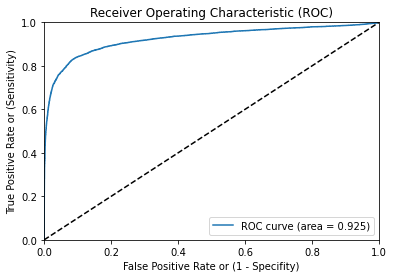

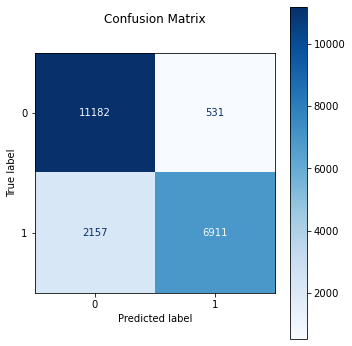

,Metric,Value,Model
0,Train_acc,0.873549,Logisitc
1,Test_acc,0.870651,Logisitc
2,rmse,0.359651,Logisitc
3,Accuracy,0.870651,Logisitc
4,Precision,0.928648,Logisitc
5,Recall,0.762131,Logisitc
6,True Positive Rate,0.954666,Logisitc
7,False Positive Rate,0.045334,Logisitc


In [35]:
logit = LogisticRegression(solver='liblinear')
logit.fit(x_train, y_train)
logit_preds = logit.predict(x_test)
logit_probs = logit.predict_proba(x_test)[:,1]
logit_probs2 = logit.predict_proba(x_test)

model_metrics = get_model_metrics(x_train, y_train, x_test, y_test, logit_preds, logit)

class_metrics = classification_metrics(x_train, y_train, x_test, y_test, logit_preds,logit_probs, logit)
y_true = y_test.values

metrics_list = [model_metrics, class_metrics]
lgrmetrics = pd.concat(metrics_list)
lgrmetrics = lgrmetrics.reset_index()
lgrmetrics['Model'] = 'Logisitc'

plt.show();
lgrmetrics

### Random Forest

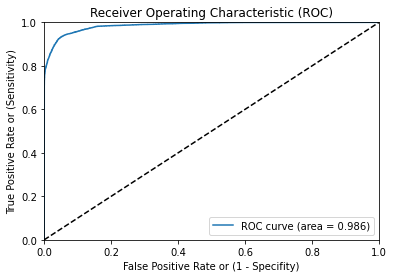

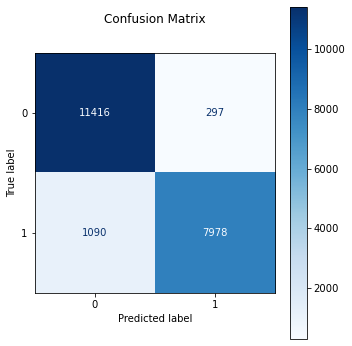

,Metric,Value,Model
0,Train_acc,0.948029,Forest
1,Test_acc,0.933256,Forest
2,rmse,0.258348,Forest
3,Accuracy,0.933256,Forest
4,Precision,0.964109,Forest
5,Recall,0.879797,Forest
6,True Positive Rate,0.974644,Forest
7,False Positive Rate,0.025356,Forest


In [49]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=10)
rfc = rfc.fit(x_train, y_train)
forest_preds = rfc.predict(x_test)
forest_probs = rfc.predict_proba(x_test)[:,1]

model_metrics = get_model_metrics(x_train, y_train, x_test, y_test, forest_preds, rfc)

class_metrics = classification_metrics(x_train, y_train, x_test, y_test, forest_preds, forest_probs, rfc)

metrics_list = [model_metrics, class_metrics]
forest_metrics = pd.concat(metrics_list)
forest_metrics['Model'] = 'Forest'
plt.show();
forest_metrics = forest_metrics.reset_index()
forest_metrics 

In [50]:
print(classification_report(y_test, forest_preds))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     11713
           1       0.96      0.88      0.92      9068

    accuracy                           0.93     20781
   macro avg       0.94      0.93      0.93     20781
weighted avg       0.94      0.93      0.93     20781



In [ ]:
importance = rfc.feature_importances_

In [ ]:
impList = zip(x_train.columns, importance)
for feature in sorted(impList, key = lambda t: t[1], reverse=True):
    print(feature) #Seems like 'food&drink' is the most impactful feature

In [894]:
with open('Passenger_satisfaction_RF-model', 'wb') as files:
    pickle.dump(rfc, files)